# Anatomy of quantum annealing with D-Wave on Amazon Braket

This tutorial notebook dives deep into the __anatomy of quantum annealing__ with D-Wave on Amazon Braket.

First, the concept of quantum annealing as used by D-Wave is introduced to show how it probabilistically finds the (approximate) optimum to some optimization problem. 

The next section introduces the structures of the D-Wave QPUs and the concept of __embedding__. Amazon Braket provides two D-Wave devices, 2000Q and Advantage. The 2000Q device has the __Chimera__ topology, while the Advantage device has the __Pegasus__ topology. Running a problem on a particular D-Wave device requires mapping the original source graph onto the target graph. This mapping is called embedding.

Finally, an example QUBO problem is solved using both the classical annealers and QPU to demonstrate the sampling process and a breakdown of the QPU access time. 

## Background: quantum annealing

__Introduction__: On a high level, quantum annealing (QA) is a specific approach to quantum computing, as opposed to the common gate-based model. 
Quantum annealers are specific-purpose machines designed to solve certain problems belonging to the class of Quadratic Unconstrained Optimization (QUBO) problems. The QUBO model unifies a rich variety of NP-hard combinatorial optimization problems, such as Quadratic Assignment Problems, Capital Budgeting Problems, Task Allocation Problems and Maximum-Cut Problems, just to name a few [1]. 
Since quantum annealers do not have to meet the strict engineering requirements that universal gate-based machines have to meet, already today this technology features $\sim5000$ superconducting qubits, compared to less than $100$ qubits on gate-model quantum computers. 
Amazon Braket offers access to the superconducting quantum annealers provided by D-Wave Systems that can be programmed using the high-level, open source tool suite called ```Ocean```. 

__Adiabatic quantum computing:__ The paradigm of QA is closely related to *adiabatic quantum computing* (with only subtle differences discussed later) [2]. 
In essence, adiabatic quantum computing makes use of an adiabatic process where parameters are changed sufficiently slow for the system to adapt to the new parameter configuration quasi-instantaneously. 
For example, in a quantum mechanical system, some Hamiltonian starts from $H_{0}$ and slowly changes to some other Hamiltonian $H_{1}$, with (for example) a linear ramp (also called schedule):

$$H(t)=(1−t)H_{0}+t H_{1},$$

where $t\in\left[0, 1\right]$ on some time scale. 
Accordingly, the system's final dynamics at $t=1$ is governed by $H_{1}$ while initially it is determined by $H_{0}$.  If the change in the time-dependent Hamiltonian $H(t)$ is sufficiently slow, the resulting dynamics are very simple (according to the adiabatic theorem): if the system starts out in an eigenstate of $H_{0}$, the system remains in an instantaneous eigenstate throughout the evolution. 
Specifically, if the system started in the ground state (the eigenstate with minimal energy), the system stays in the ground state, if the condition of adiabaticity (that is related to energy difference between the ground state and the first excited state called the __gap__) is satisfied. 
This means, to solve a (unknown) ground state of a Hamiltonian for a (hard-to-solve) problem, one can start from an easy-to-solve Hamiltonian with a known ground state. 

__Quantum Annealing:__ In practice, it is very difficult to fulfill the adiabaticity conditions, because of undesired noise. 
Therefore, quantum annealers forego the stringent, theoretical adiabaticity conditions and heuristically repeat the annealing procedure many times, thereby collecting a number of samples from which the configuration with the lowest energy can be selected as the optimal solution. However, there is no strict guarantee to find the true ground state.

Typically the Hamiltonian $H_{0}$ has the form: $H_{0}=\sum_i \sigma_{i}^{x}$; with well-known ground state (the equal superposition of all bitstrings).
And $H_{1}$ is described by the canonical Ising model 

$$H_{\mathrm{Ising}}=\sum_{i,j}J_{i,j}\sigma_{i}^{z}\sigma_{j}^{z}.$$ 

Accordingly, the problem to solve must be written in this form. 
Since there is a one-to-one correspondence between this Ising Hamiltonian and QUBO problems, within ```Ocean``` you can define your problem either as QUBO or Ising matrix. 

However, note that quantum annealers only come with __limited connectivity__, because not every qubit $i$ is connected to every other qubit $j$. 
If the problem's connectivity does not match that of the hardware, you must find a __minor embedding__, where several physical qubits are combined into one logical qubit, as discussed in the next section. 

## Background: embedding

To solve a real-world problem such as some scheduling problem or a traveling salesman problem with a quantum annealer as provided by D-Wave, in essence two subproblems need to be solved: 
* __Reduction__: First, to map the use case to QUBO (or the equivalent Ising) form written as

$$\mathrm{min} \hspace{0.1cm} y=x^{\intercal}Qx + x^{\intercal}B + c,$$ 

where $x=(x_{1}, x_{2}, \dots)$ is a vector of binary decision variables $x_{i}=0,1$ (whereas Ising problems are formulated in terms of binary Ising variables $z_{i}=-1,1$ with the affine mapping $x_{i}=(z_{i}+1)/2$, i.e., $z_{i}=2x_{i}-1$). Note that QUBO problems can be simplified using $x_{i}^{2}=x_{i}$ for $x_{i}=0,1$. For an excellent overview on how to convert many NP-hard use cases to QUBO form, refer to Ref.[1].
* __Embedding__: Second, the logical problem with connections expressed by the matrix $Q$ has to be mapped to the underlying hardware. In the case of the D-Wave 2000Q device this is a Chimera graph, while for the Advantage device this is a Peganus graph. 

The approach to address the embedding problem is given by the __minor embedding__ technique:
A minor-embedding is a mapping that maps a (logical) graph $G$ to a sub-graph of another (hardware) graph $U$. 
One can solve problems with higher connectivity directly on the sparsely connected chip, by sacrificing physical qubits accordingly to the connectivity of problem, introducing a certain overhead with multiple physical qubits making up one logical variable. For illustration, the following shows an example on how to embed a highly connected graph (with maximum degree 5) to a more sparsely connected graph (with maximum degree 3 only), where (after the embedding) the logical node 1 is encoded by three physical qubits that are strongly interlinked with each other to ensure a common encoding (without chain breaking).   

<div>
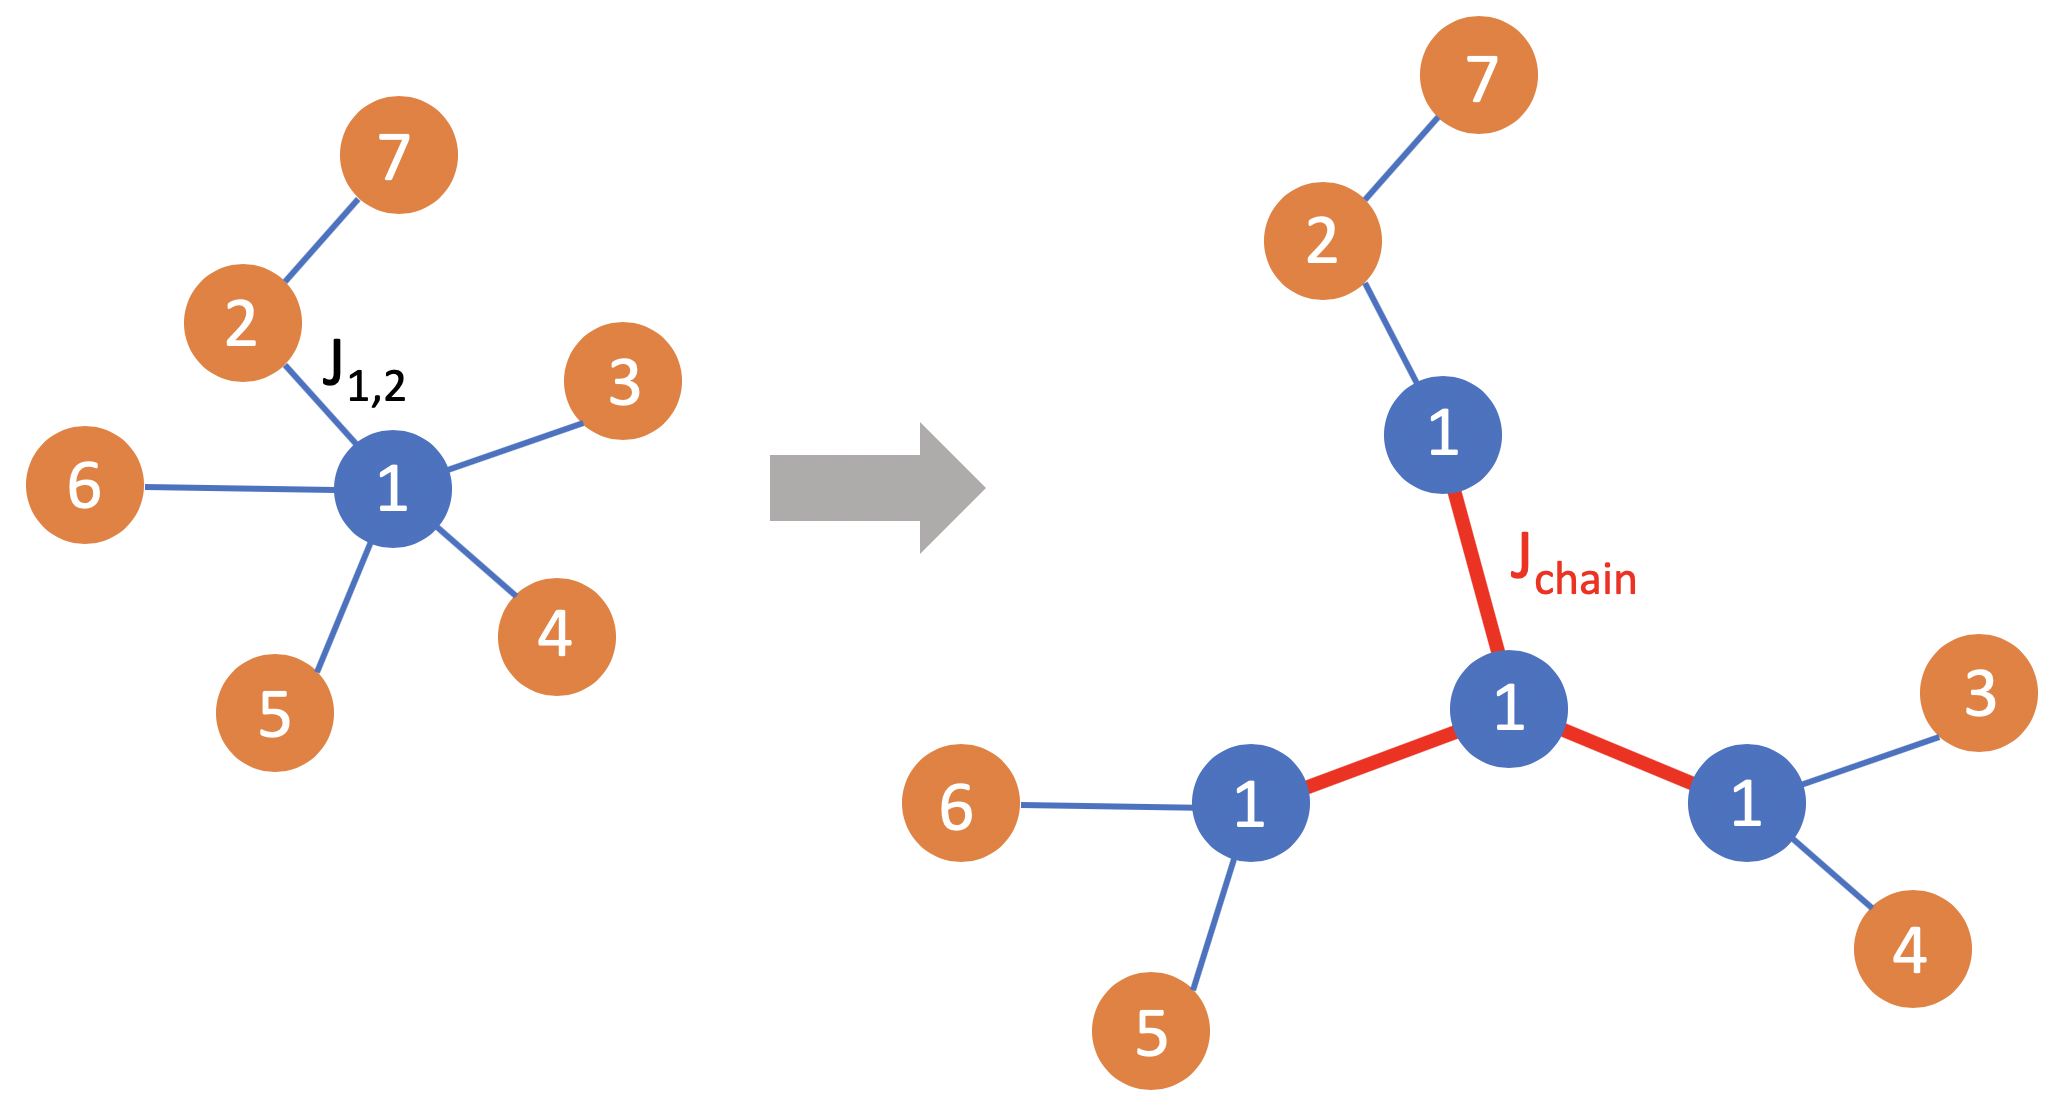
</div>

The minor embedding problem itself is NP-hard: For example, for problems where the number of logical variables is more than 64, there is no guarantee to find an embedding on the D-Wave 2000Q device. The embedding process is normally implemented when a sampler method is called, while one can manually find graph minors, using a method called _Minorminer_ (developed by D-Wave). 


## Imports and setup

In [1]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx
import dwave_networkx as dnx
import minorminer
import dimod
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Enter your desired device and S3 location (bucket and prefix). Remember that bucket names for Amazon Braket always begin with "amazon-braket-".

In [3]:
# choose the D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

# or choose the D-Wave Advantage device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)
Device: Device('name': Advantage_system4.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system4)


In [4]:
# investigate D-Wave device properties
device.properties.provider
device_name = device.name
qubit_count = device.properties.provider.qubitCount
number_couplers = len(device.properties.provider.couplers)
shots_range = device.properties.service.shotsRange
print('Running on {} with {} physical qubits, {} couplers and shots in the range {}.'.format(device_name,
                                                                                             qubit_count,
                                                                                             number_couplers,
                                                                                             shots_range))

Running on Advantage_system4.1 with 5760 physical qubits, 40279 couplers and shots in the range (1, 10000).


## The structures of D-Wave QPUs

D-Wave's 2000Q hardware has a Chimera graph, which has 2048 qubits, consisting of $16 \times 16$ unit cells of $8$ qubits each.
The connectivity within such a unit cell of the Chimera graph is displayed in the following figure (taken from the D-Wave documentation [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html)):  

<div>
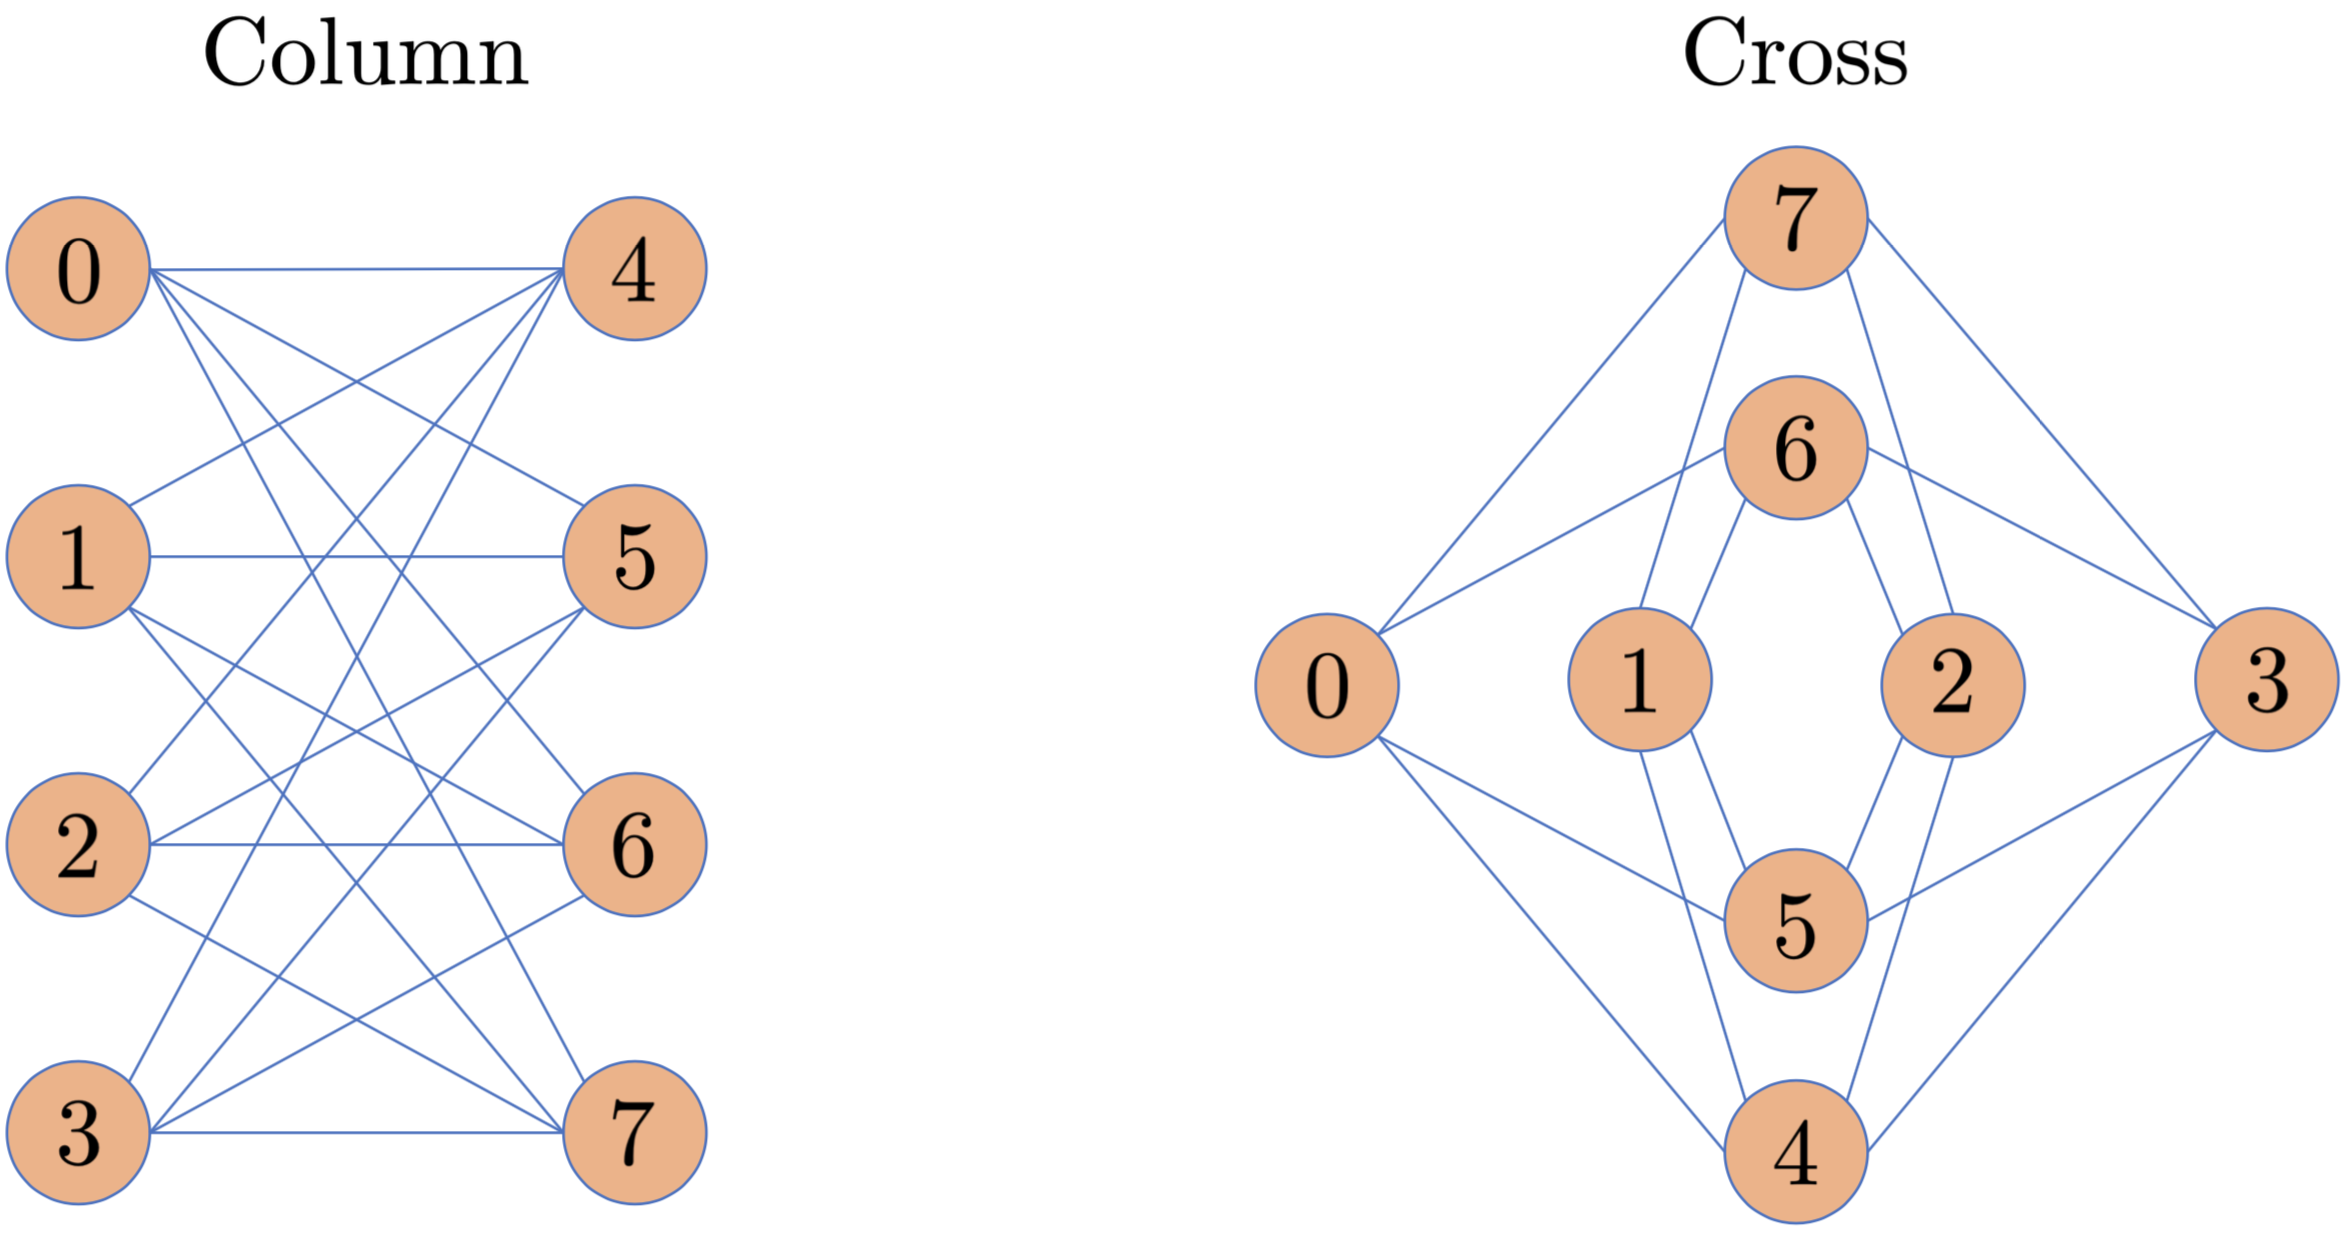
</div>

The Advantage hardware has a Pegasus graph, with in total 5760 qubits. The structure and the connectivity of the Pegasus graph can be described with the following figure (also taken [here](https://docs.dwavesys.com/docs/latest/c_gs_4.html)):


<div>
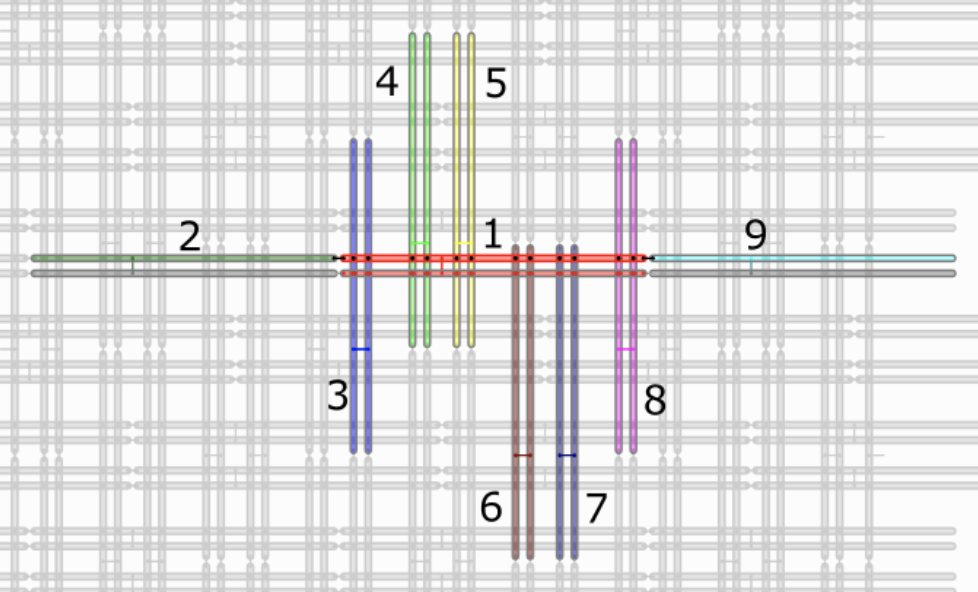
</div>

In the figure, each colored loop can be regarded as one qubit, which is associated with an odd coupler to form a pair (qubits of the same color). Take the example of qubit 1 (in red): It is internally coupled with 12 qubits (3,4,5,6,7,8) and externally coupled with 2 adjacent qubits (2,9) in the same direction.

__Working graph__: In a D-Wave QPU, the set of qubits and couplers that are available for computation is known as the *working graph*. Because of production imperfections, the yield of a working graph is typically less than the total number of qubits and couplers that are fabricated and physically present in the QPU.

Both the Chimera and the Pegasus graphs are available as a ```networkx``` graph in the package ```dwave_networkx```. 
Using this package, you can visualize some small versions of both graphs [2,3]. 

### The Chimera graph

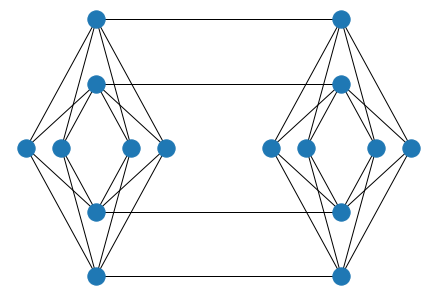

In [5]:
# show 1x2 Chimera graph
connectivity_structure = dnx.chimera_graph(1, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

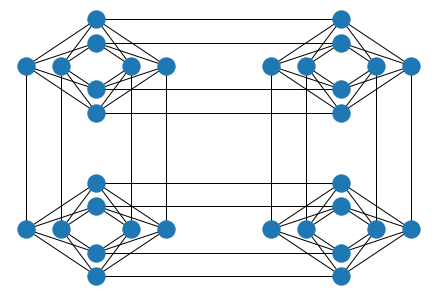

In [6]:
# show 2x2 Chimera graph
connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

### The Pegasus graph

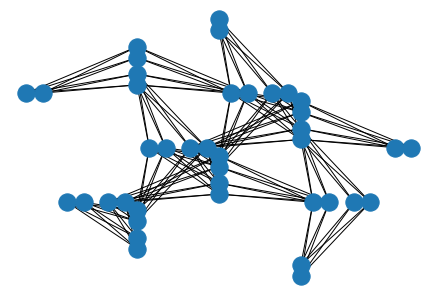

In [7]:
# show the basic Pegasus graph
connectivity_structure = dnx.pegasus_graph(2)
dnx.draw_pegasus(connectivity_structure)
plt.show()

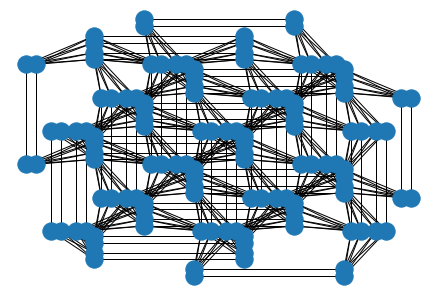

In [8]:
# show a larger Pegasus graph
connectivity_structure = dnx.pegasus_graph(3)
dnx.draw_pegasus(connectivity_structure)
plt.show()

## Finding an embedding  

The next cell generates a fully-connected graph with 9 vertices and $4\times8=32$ nodes. Such fully connected graphs cannot fit onto the sparse graph of the underlying hardware. The following example shows how to use the ```minorminer``` funtion to find an embedding on a Chimera graph.

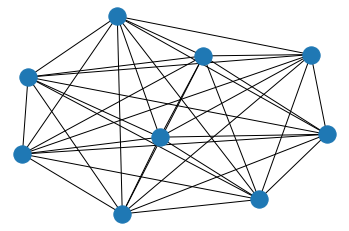

In [9]:
# generate a fully connected graph with 9 qubits
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

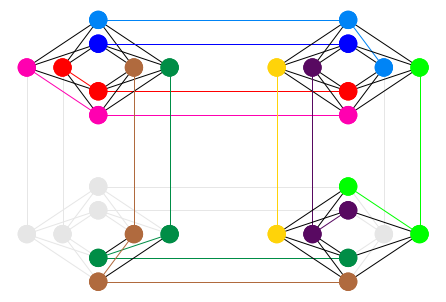

In [10]:
# find an embedding on Chimera using minorminer
connectivity_structure = dnx.chimera_graph(2, 2)
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

# plot this mebedding
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

Here, qubits that have the same color correspond to one logical variable in the original problem defined by the $K_{9}$ graph. Qubits combined in such way form a chain. Even though the problem only has $9$ variables (nodes), a large portion of all 32 available physical qubits are used on the toy Chimera graph.

In [11]:
# print the embedding
print(embedded_graph.items())

dict_items([(0, [5, 13]), (1, [11, 27, 28]), (2, [1, 14, 6]), (3, [15, 7, 0]), (4, [8, 24]), (5, [12, 10, 4]), (6, [30, 3, 22, 19]), (7, [31, 18, 23, 2]), (8, [25, 29, 9])])


In [12]:
# find the maximum chain length
max_chain_length = 0
for _, chain in embedded_graph.items():
    if len(chain) > max_chain_length:
        max_chain_length = len(chain)
print('Maximum chain length in embedded graph (overhead):', max_chain_length)

Maximum chain length in embedded graph (overhead): 4


The chain on the hardware is implemented by having very strong couplings between the elements in a chain (as indicated by the bold, red connections $J_{\mathrm{chain}}$ in the first figure), chosen to be twice as strong as what the user can set. 
This enforces physical qubits to take on the same logical value. 
Still, long chains can break, leading to inconsistent results. 
In general, shorter chains (with smaller overhead) are preferable, so you do not waste physical qubits and can obtain more reliable results [2].

## Setting up and solving QUBO problems 

This section shows how to set up and solve a QUBO (or Ising) problem. This demonstration uses several sampling strategies: ```SimulatedAnnealingSampler``` and ```ExactSolver``` are used for classical benchmarking; next, the same problem is solved with the D-Wave's QPU using ```BraketDWaveSampler```. 

In general, any sampler accepts a binary quadratic model (BQM) as defined in the next cell as model input and returns variable assignments in its response. 

### Problem setup

The example considered in this section is a graph-coloring problem on a simple, small graph with five vertices (labelled $0$ to $4$), six edges and maximum degree of three, as illustrated below. 
The aim is to find a partition of all nodes into two subsets with maximum cut. 
Here, one scores a point whenever an edge connects two nodes with different colors. 
This is the NP-hard [Maximum-Cut problem](https://en.wikipedia.org/wiki/Maximum_cut). 
<div>
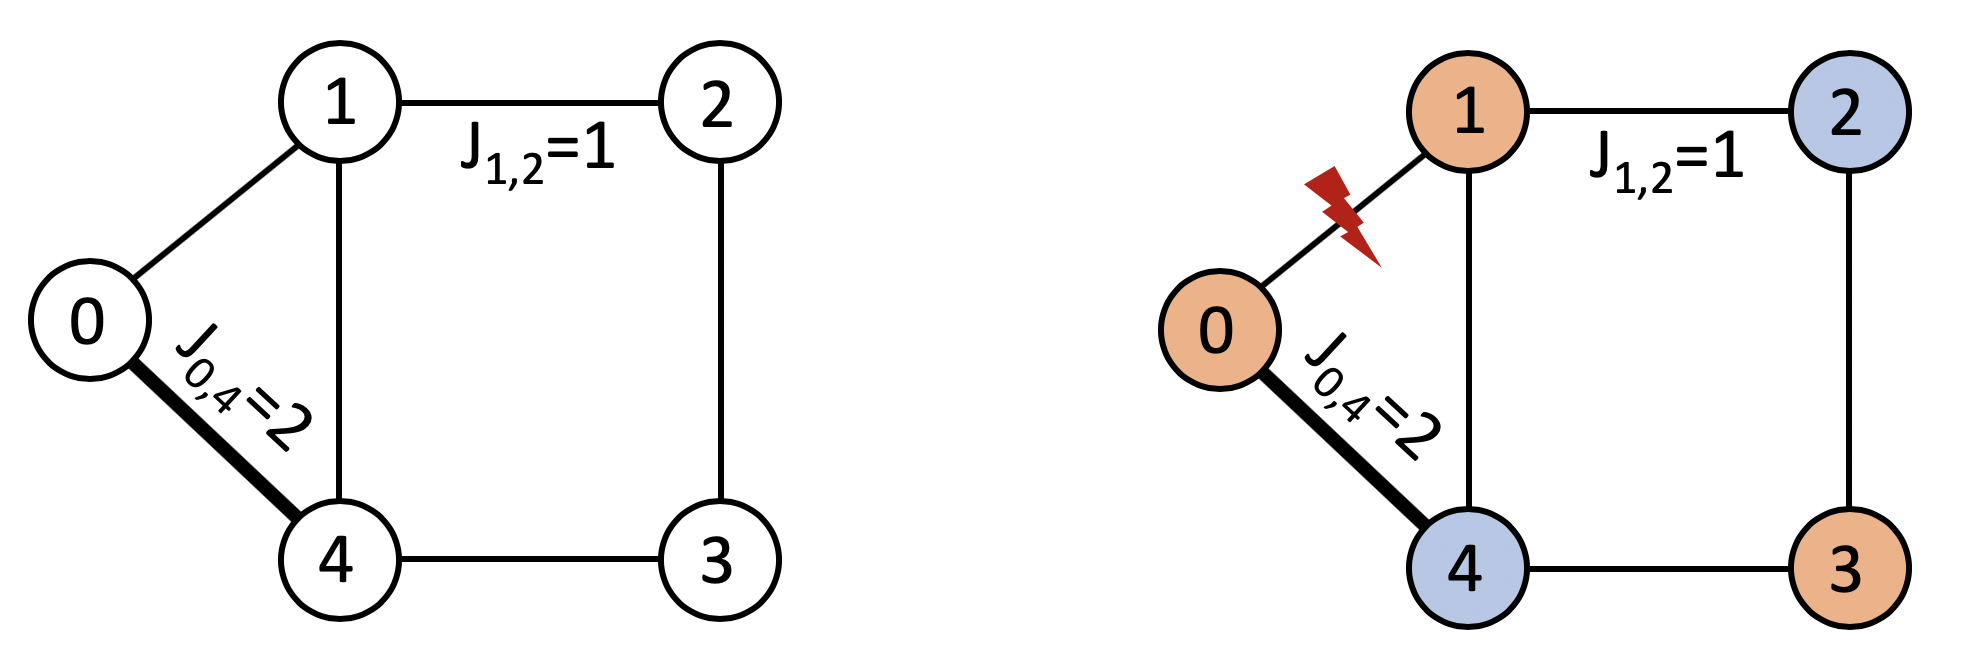
</div>

The problem is set up by defining (i) a constant offset term (which only affects the value of the energy but does not affect the variable configuration), and both (ii) linear and (iii) quadratic terms defined as dictionaries, as shown in the next cell. 

In [13]:
# define QUBO problem as BinaryQuadraticModel
quadratic = {(0, 1): 1.0, (0,4): 2.0, (1, 2): 1.0, (1,4): 1.0, (2, 3): 1.0, (3, 4): 1.0}
linear = {}
offset = 0.0

### Classical benchmark: simulated annealing

First, run this problem using (classical) simulated annealing, as offered as part of D-Wave's ```dimod``` module. ```SimulatedAnnealingSampler``` is a [reference implementation](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampler_composites/samplers.html#module-dimod.reference.samplers.simulated_annealing) of a simulated annealing sampler, with ```neal.sampler.SimulatedAnnealingSampler``` being a more performant implementation of simulated annealing you may try to use for solving problems. 
The following formulates this problem in Ising form with variables that take on the values $\pm 1$.

In [14]:
# set parameters
num_shots = 10
vartype = dimod.SPIN

# run classical simulated annealing
model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=num_shots)

# print results
print(response)

   0  1  2  3  4 energy num_oc.
0 +1 +1 -1 +1 -1   -5.0       1
1 -1 -1 +1 -1 +1   -5.0       1
2 +1 +1 -1 +1 -1   -5.0       1
3 +1 +1 -1 +1 -1   -5.0       1
4 -1 -1 +1 -1 +1   -5.0       1
5 +1 +1 -1 +1 -1   -5.0       1
6 -1 -1 +1 -1 +1   -5.0       1
7 -1 -1 +1 -1 +1   -5.0       1
8 +1 +1 -1 +1 -1   -5.0       1
9 +1 +1 -1 +1 -1   -5.0       1
['SPIN', 10 rows, 10 samples, 5 variables]


The ```response``` object lists all sampling results as individual rows, with energy and number of occurrences for each case. 
You can access this information in more compact form using the ```aggregate()``` method as shown in the next cell and described [here](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/generated/dimod.SampleSet.aggregate.html). 

In [15]:
# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 +1 +1 -1 +1 -1   -5.0       6
1 -1 -1 +1 -1 +1   -5.0       4
['SPIN', 2 rows, 10 samples, 5 variables]


The two degenerate optimal solutions with energy $-5.0$ are connected by a so-called $\mathbb{Z}_{2}$ symmetry. 
This means that the choice of coloring is arbitrary, since it does not make a difference if coloring one set of nodes $\{0,1,3\}$ red and the remaining ones $\{2,4\}$ blue or the other way around. 
However, if you add one linear term, this symmetry is broken and a unique solution is preferred as shown in the next cell. 

In [16]:
# modify QUBO: add a linear term
linear_break = {0: +1.0}

# run classical simulated annealing
model = dimod.BinaryQuadraticModel(linear_break, quadratic, offset, vartype)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=num_shots)

# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

   0  1  2  3  4 energy num_oc.
0 -1 -1 +1 -1 +1   -6.0      10
['SPIN', 1 rows, 10 samples, 5 variables]


In [17]:
# determine the minimum
min_energy = min(response.data_vectors['energy'])
print('Minimal energy:', min_energy)

Minimal energy: -6.0


### Classical benchmark: ```ExactSolver```

Alternatively, for this small introductory problem, you can use the ```ExactSolver```. 
The ```ExactSolver``` is a simple exact solver for testing and debugging code using the local CPU. 
Note that this solver becomes [slow](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampler_composites/samplers.html#samplers) for problems with $\sim18$ or more variables.
The ```ExactSolver``` simply reports all $2^{N}$ configurations with corresponding energies. 

In [18]:
# run exact solver
model = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
sampler = dimod.ExactSolver()
response = sampler.sample(model)

# response aggregate
response_aggregate = response.aggregate()
print(response_aggregate)

    0  1  2  3  4 energy num_oc.
8  -1 -1 +1 -1 +1   -5.0       1
29 +1 +1 -1 +1 -1   -5.0       1
4  -1 +1 -1 -1 +1   -3.0       1
9  +1 -1 +1 -1 +1   -3.0       1
11 -1 +1 +1 -1 +1   -3.0       1
14 +1 -1 +1 -1 -1   -3.0       1
17 +1 -1 +1 +1 -1   -3.0       1
27 -1 +1 -1 +1 +1   -3.0       1
28 -1 +1 -1 +1 -1   -3.0       1
30 +1 -1 -1 +1 -1   -3.0       1
2  +1 +1 -1 -1 -1   -1.0       1
7  -1 -1 -1 -1 +1   -1.0       1
13 +1 +1 +1 -1 -1   -1.0       1
18 +1 +1 +1 +1 -1   -1.0       1
23 -1 -1 +1 +1 +1   -1.0       1
24 -1 -1 -1 +1 +1   -1.0       1
1  +1 -1 -1 -1 -1    1.0       1
3  -1 +1 -1 -1 -1    1.0       1
6  +1 -1 -1 -1 +1    1.0       1
12 -1 +1 +1 -1 -1    1.0       1
19 -1 +1 +1 +1 -1    1.0       1
20 -1 +1 +1 +1 +1    1.0       1
22 +1 -1 +1 +1 +1    1.0       1
25 +1 -1 -1 +1 +1    1.0       1
5  +1 +1 -1 -1 +1    3.0       1
10 +1 +1 +1 -1 +1    3.0       1
15 -1 -1 +1 -1 -1    3.0       1
16 -1 -1 +1 +1 -1    3.0       1
26 +1 +1 -1 +1 +1    3.0       1
31 -1 -1 -

### Quantum annealing on D-Wave QPUs

This section shows how to run the same problem on D-Wave's QPUs using ```BraketDWaveSampler```. Some important features are discussed in the following:  
* __Number of samples__: The parameter ```num_reads``` sets the number of samples. Given the probabilistic nature of quantum annealing, the annealer will not find the optimal solution in every single run, but for the simple problem considered here the vast majority of runs should find one of the two optimal bitstrings. 
* __Storage of results__: All results are reliably stored in the S3 location given as an input when calling the ```BraketDWaveSampler``` object. 
* __Physical vs. logical variables__: If samples agree on the logical encoding level, but are different on the physical level (because chains may break, as discussed before), then (for full transparency) D-Wave reports these as separate rows. If this information is somewhat redundant for you, you may simplify the output by calling the ```aggregate()``` method. 
* __Embedding__: D-Wave's ```EmbeddingComposite()``` implements the minor-mapping strategy, by mapping the problem graph to D-Wave system’s numerically indexed qubits. Note that a new embedding is found each time when a sampling method is called. If you want to reuse an embedding, you can use the ```LazyFixedEmbeddingComposite()``` method. If you want to provide your own embedding, you can do so by using ```FixedEmbeddingComposite()``` instead. More embedding options and details on composites can be found [here](https://docs.ocean.dwavesys.com/projects/system/en/stable/reference/composites.html). 

In [19]:
# set parameters
num_reads = 1000
vartype = dimod.SPIN

# define BQM
bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

# run BQM: solve with the D-Wave 2000Q device
sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
sampleset = sampler.sample(bqm, num_reads=num_reads)

# print solution
print(sampleset)

    0  1  2  3  4 energy num_oc. chain_.
0  -1 -1 +1 -1 +1   -5.0     402     0.0
1  +1 +1 -1 +1 -1   -5.0     578     0.0
2  +1 -1 +1 -1 +1   -3.0       2     0.0
3  -1 +1 -1 +1 +1   -3.0       1     0.0
4  -1 +1 -1 +1 -1   -3.0       2     0.0
5  +1 -1 +1 +1 -1   -3.0       2     0.0
6  +1 -1 -1 +1 -1   -3.0       2     0.0
7  -1 +1 -1 -1 +1   -3.0       3     0.0
8  -1 +1 +1 -1 +1   -3.0       1     0.0
9  +1 -1 +1 -1 -1   -3.0       6     0.0
10 +1 +1 +1 +1 -1   -1.0       1     0.0
['SPIN', 11 rows, 1000 samples, 5 variables]


In the output you may see identical logical results listed as separate rows in the sample set results object. 
See for example the first and third lines in the screen shot below. 
This is because these results are different on the physical level of variables, as evident from the last column ```chain_.``` giving different chain breaking results and therefore indicating different configurations on the physical level. 
If you are not interested about this extra information, and are only concerned about the logical level, you can call ```aggregate()``` to simplify the output, as shown in the next cell. 
<div>
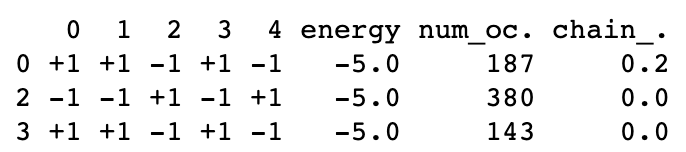
</div>

In [20]:
# aggregate solution: 
sampleset = sampleset.aggregate()

# print solution
print(sampleset)

    0  1  2  3  4 energy num_oc. chain_.
0  -1 -1 +1 -1 +1   -5.0     402     0.0
1  +1 +1 -1 +1 -1   -5.0     578     0.0
2  +1 -1 +1 -1 +1   -3.0       2     0.0
3  -1 +1 -1 +1 +1   -3.0       1     0.0
4  -1 +1 -1 +1 -1   -3.0       2     0.0
5  +1 -1 +1 +1 -1   -3.0       2     0.0
6  +1 -1 -1 +1 -1   -3.0       2     0.0
7  -1 +1 -1 -1 +1   -3.0       3     0.0
8  -1 +1 +1 -1 +1   -3.0       1     0.0
9  +1 -1 +1 -1 -1   -3.0       6     0.0
10 +1 +1 +1 +1 -1   -1.0       1     0.0
['SPIN', 11 rows, 1000 samples, 5 variables]


## Experiments with annealing parameters

This section dives deeper into the sampling process as performed on D-Wave's QPU. 
To this end, a breakdown of the QPU access time as a function of the QUBO problem size and input parameters is analyzed. 
As shown in the next cell, you can access several timing-related fields available in D-Wave’s Ocean SDK, using the ```info``` field in the dimod sample set class. Compare information available [here](https://docs.dwavesys.com/docs/latest/c_timing_5.html#qpu-timing-information-from-ocean-software). 

In [21]:
# print timing info for the previous D-Wave job
sampleset.info['additionalMetadata']['dwaveMetadata']['timing']

{'qpuSamplingTime': 238940,
 'qpuAnnealTimePerSample': 20,
 'qpuAccessTime': 249630,
 'qpuAccessOverheadTime': 2075,
 'qpuReadoutTimePerSample': 198,
 'qpuProgrammingTime': 10690,
 'qpuDelayTimePerSample': 20,
 'postProcessingOverheadTime': 411,
 'totalPostProcessingTime': 411,
 'totalRealTime': None,
 'runTimeChip': None,
 'annealTimePerRun': None,
 'readoutTimePerRun': None}

This experiment focuses on the total QPU access time ```QpuAccessTime``` which can be broken up into two contributions: 
(1) a one-time initialization step to program the QPU (given by ```QpuProgrammingTime```), and 
(2) the total sampling time ```QpuSamplingTime``` that is made of repeated sampling runs involving per-sample timescales such as ```QpuAnnealTimePerSample``` and ```QpuReadoutTimePerSample```.
For more details, refer to [this page](https://docs.dwavesys.com/docs/latest/c_timing_2.html#breakdown-of-qpu-access-time) in the Ocean documentation.  

The following analyzes how these timescales depend on the number of logical variables for a canonical NP-hard QUBO problem, namely a specific graph partitioning problem as described in great detail [here](https://github.com/dwave-examples/graph-partitioning).
In short, here the goal is to partition all nodes into two subsets of equal size while minimizing the number of cut edges between these two subsets. 
In other words, one needs to color the graph such to have the same number of blue and red nodes with the number of edges connecting blue and red nodes being as small as possible. 

### Helper functions

First, set up some helper functions. 
The function ```get_graph``` plots a given graph using the ```networkx``` library. 
The function ```get_model``` generates the QUBO $Q$-matrix for graph partitioning problem based on a random graph with a given number of nodes and edge probability. 
The function ```run_qubo``` runs the QUBO problem for given graph $G$, associated QUBO-Matrix $Q$ and number of shots, outputting several timescales discussed before. 

In [22]:
# helper function to plot a graph
def get_graph(graph, pos):
    """
    plot given graph with fixed positioning
    """
    
    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [23]:
# helper function to generate the model
def get_model(nodes, prob=0.2, gamma=80):
    """
    function to generate Q matrix for graph partitioning problem 
    """
    
    # ------- Set up the graph -------
    vertices = nodes
    G = nx.gnp_random_graph(vertices, prob)

    print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                               len(G.edges), 
                                                                               len(G.nodes) * (len(G.nodes)-1) / 2))

    # ------- Plot the graph -------
    pos = nx.spring_layout(G)
    # plot graph with labels
    get_graph(G, pos)

    # ------- Set up QUBO dictionary -------

    # initialize a Q matrix
    Q = defaultdict(int)

    # fill in the Q matrix
    for u, v in G.edges:
        Q[(u,u)] += 1
        Q[(v,v)] += 1
        Q[(u,v)] += -2

    for i in G.nodes:
        Q[(i,i)] += gamma*(1-len(G.nodes))

    for i, j in combinations(G.nodes, 2):
        Q[(i,j)] += 2*gamma
    
    return G, Q

In [24]:
# helper function to run the QUBO problem
def run_qubo(G, Q, gamma=80, num_reads=1000, annealing_time=20):
    """
    run QUBO problem for given graph G, Qubo-Matrix Q and number of shots
    """
    # ------- Run the QUBO problme on the QPU -------

    # set chain strength
    nodes = len(G.nodes)
    chain_strength = gamma*nodes

    # run QUBO on Braket and keep track of runtime
    start = time.time()
    response = sampler.sample_qubo(Q, chain_strength=chain_strength, 
                                   num_reads=num_reads,
                                   annealing_time=annealing_time)
    end = time.time()
    
    # print and store runtime (wallclock time)
    runtime = end - start
    print('Runtime is {} for {} nodes.'.format(runtime, nodes))
    
    # D-Wave timescales
    QpuSamplingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuSamplingTime']
    QpuAccessTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']
    QpuProgrammingTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuProgrammingTime']
    QpuAnnealTimePerSample = response.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAnnealTimePerSample']
    # TotalRealTime = response.info['additionalMetadata']['dwaveMetadata']['timing']['totalRealTime']
    # RunTimeChip = response.info['additionalMetadata']['dwaveMetadata']['timing']['runTimeChip']
    print('QpuProgrammingTime is {} for {} nodes.'.format(QpuProgrammingTime, nodes))
    print('QpuSamplingTime is {} for {} nodes.'.format(QpuSamplingTime, nodes))
    print('QpuAccessTime is {} for {} nodes.'.format(QpuAccessTime, nodes))
    print('QpuAnnealTimePerSample is {} for {} nodes.'.format(QpuAnnealTimePerSample, nodes))
    
    # see if the best solution found is feasible, and if so print the number of cut edges.
    sample = response.record.sample[0]

    # postprocessing: analyze result
    # in the case when n is odd, the set may have one more or one fewer nodes
    if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
        num_cut_edges = 0
        for u, v in G.edges:
            num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
        print("Valid partition found with", num_cut_edges, "cut edges.")
    else:
        print("Invalid partition.")
    
    # plot result
    colors = sample
    colorlist = ['#377eb8','#e41a1c']
    nx.draw_networkx(graph, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    plt.axis('off');
    plt.show();
    
    # results as dic
    results = {'runtime': runtime, 
               'QpuSamplingTime': QpuSamplingTime,
               'QpuAccessTime': QpuAccessTime, 
               'QpuProgrammingTime': QpuProgrammingTime,
               'QpuAnnealTimePerSample': QpuAnnealTimePerSample
              }
    
    return results

### Experimental runs

Graph on 10 nodes created with 6 out of 45.0 possible edges.
Runtime is 2.411226987838745 for 10 nodes.
QpuProgrammingTime is 10766 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13055 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 2 cut edges.
Graph on 20 nodes created with 35 out of 190.0 possible edges.
Runtime is 5.242871999740601 for 20 nodes.
QpuProgrammingTime is 10826 for 20 nodes.
QpuSamplingTime is 2341 for 20 nodes.
QpuAccessTime is 13167 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 18 cut edges.
Graph on 30 nodes created with 92 out of 435.0 possible edges.
Runtime is 9.534066915512085 for 30 nodes.
QpuProgrammingTime is 10893 for 30 nodes.
QpuSamplingTime is 2341 for 30 nodes.
QpuAccessTime is 13234 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 47 cut edges.
Graph on 40 nodes created with 151 out of 780.0 possible edges.
Runtime is 17.1718

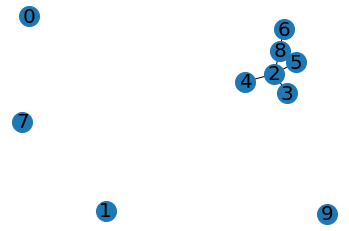

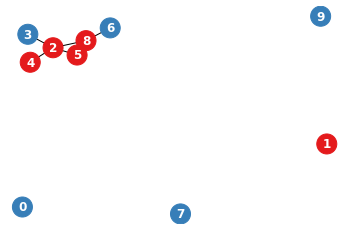

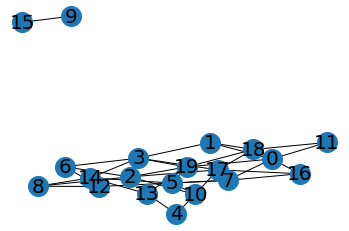

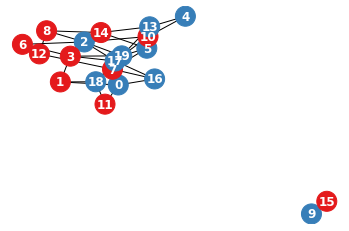

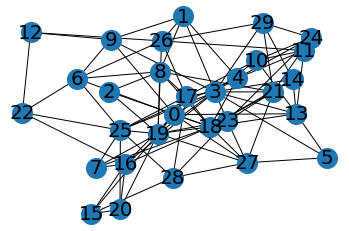

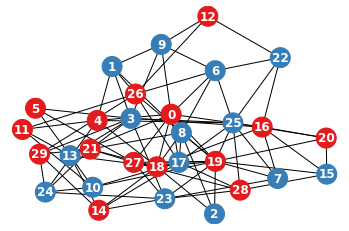

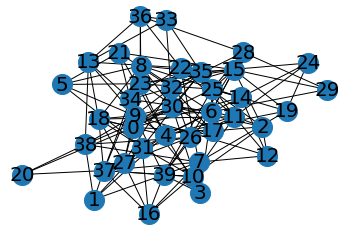

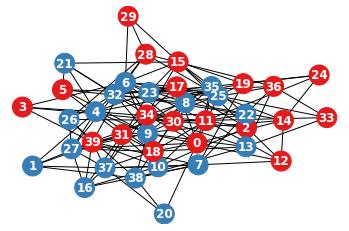

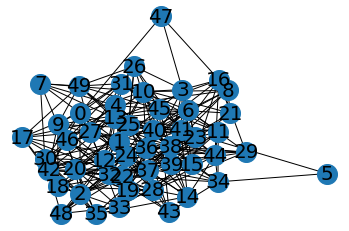

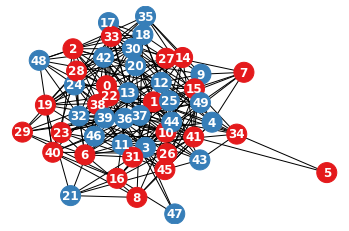

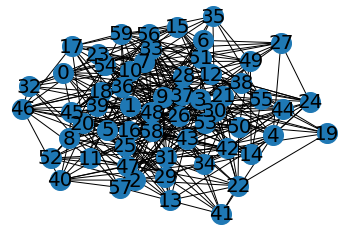

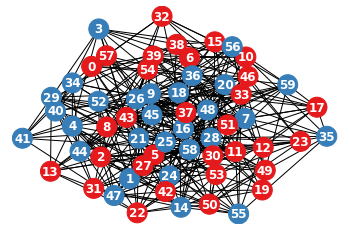

In [25]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes = [] # stores individual runtimes
QpuSamplingTimes = [] 
QpuAccessTimes = [] 
QpuProgrammingTimes = [] 
QpuAnnealTimePerSamples = []

# run for different problem sizes 
for nn in nodes:
    # define the problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes.append(runtime)
    QpuSamplingTimes.append(QpuSamplingTime)
    QpuAccessTimes.append(QpuAccessTime)
    QpuProgrammingTimes.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples.append(QpuAnnealTimePerSample)

A second set of experiments is conducted with the same parameters in order to verify the trends. 

Graph on 10 nodes created with 12 out of 45.0 possible edges.
Runtime is 3.0159189701080322 for 10 nodes.
QpuProgrammingTime is 10760 for 10 nodes.
QpuSamplingTime is 2289 for 10 nodes.
QpuAccessTime is 13049 for 10 nodes.
QpuAnnealTimePerSample is 10 for 10 nodes.
Valid partition found with 5 cut edges.
Graph on 20 nodes created with 36 out of 190.0 possible edges.
Runtime is 3.2287049293518066 for 20 nodes.
QpuProgrammingTime is 10874 for 20 nodes.
QpuSamplingTime is 2325 for 20 nodes.
QpuAccessTime is 13199 for 20 nodes.
QpuAnnealTimePerSample is 10 for 20 nodes.
Valid partition found with 15 cut edges.
Graph on 30 nodes created with 85 out of 435.0 possible edges.
Runtime is 7.027450799942017 for 30 nodes.
QpuProgrammingTime is 10884 for 30 nodes.
QpuSamplingTime is 2344 for 30 nodes.
QpuAccessTime is 13228 for 30 nodes.
QpuAnnealTimePerSample is 10 for 30 nodes.
Valid partition found with 43 cut edges.
Graph on 40 nodes created with 160 out of 780.0 possible edges.
Runtime is 13.0

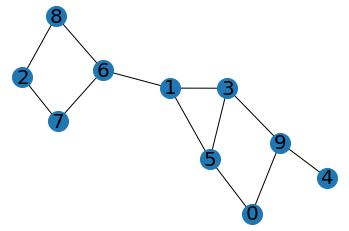

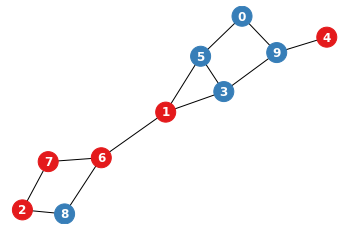

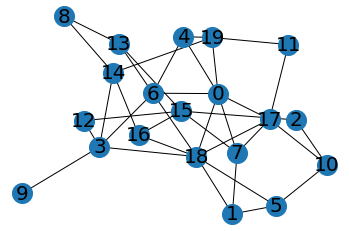

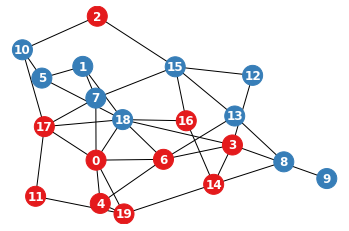

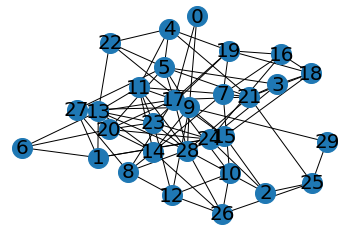

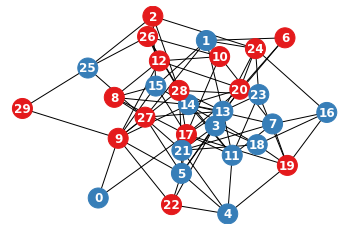

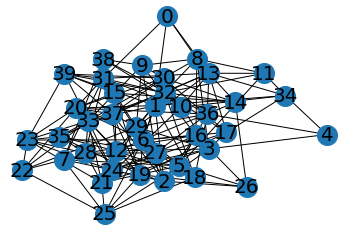

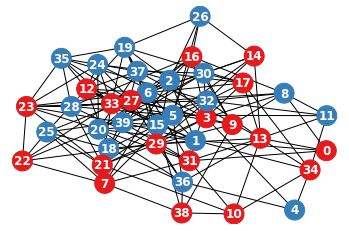

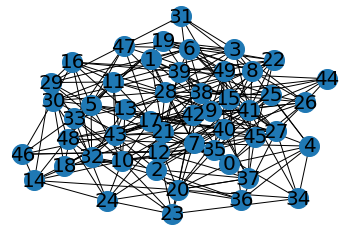

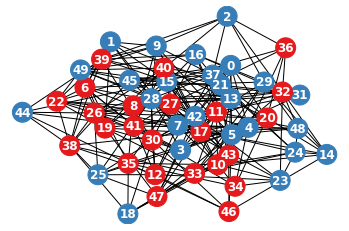

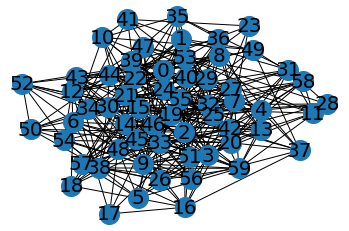

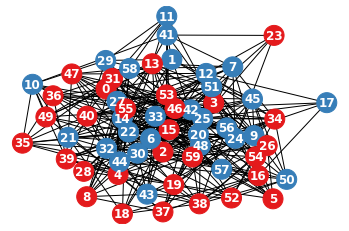

In [26]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 10 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes2 = [] # stores individual runtimes
QpuSamplingTimes2 = [] 
QpuAccessTimes2 = [] 
QpuProgrammingTimes2 = [] 
QpuAnnealTimePerSamples2 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes2.append(runtime)
    QpuSamplingTimes2.append(QpuSamplingTime)
    QpuAccessTimes2.append(QpuAccessTime)
    QpuProgrammingTimes2.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples2.append(QpuAnnealTimePerSample)

### Results visualization

OSError: [Errno 30] Read-only file system: 'dwave_wallclock_partitioning_shots_10_anneal_10.png'

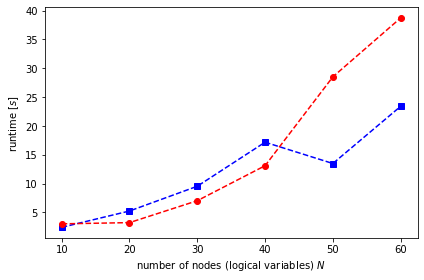

In [27]:
# plot wallclock results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot QpuSamplingTimes results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot QpuAccessTimes results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot QpuProgrammingTimes results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot QpuAnnealTimePerSamples results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

With those results, the following observations can be made: 
The wallclock time a user experiences tends to increase with the number of variables, potentially showing spikes that can come from somewhat random queuing times. 
All other timescales are independent of queuing. 
The total QPU access time increases with the number of variables, following the trend given by the QPU programming time, while the QPU sampling time is a flat contribution to the QPU access time. 
The QPU annealing time per sample is constant, taking on the value set with the ```annealing_time``` parameter.
To investigate the dependence of all timescales on this parameter, the following runs another set of experiments with a different value for this parameter. 

In [ ]:
# set parameters
prob = 0.2 # probability for edge creation
shots = 10 # number of shots
anneal_time = 100 # annealing time in us (default=20)
nodes = [10, 20, 30, 40, 50, 60] # number of variables
runtimes3 = [] # stores individual runtimes
QpuSamplingTimes3 = [] 
QpuAccessTimes3 = [] 
QpuProgrammingTimes3 = [] 
QpuAnnealTimePerSamples3 = []

# run for different problem sizes 
for nn in nodes:
    # define problem
    graph, qubo_matrix = get_model(nn, prob=prob)
    # run on D-Wave and track runtime
    results = run_qubo(graph, qubo_matrix, num_reads=shots, annealing_time=anneal_time)
    # append results
    runtime = results['runtime'] 
    QpuSamplingTime = results['QpuSamplingTime'] 
    QpuAccessTime = results['QpuAccessTime']  
    QpuProgrammingTime = results['QpuProgrammingTime']
    QpuAnnealTimePerSample = results['QpuAnnealTimePerSample']
    
    runtimes3.append(runtime)
    QpuSamplingTimes3.append(QpuSamplingTime)
    QpuAccessTimes3.append(QpuAccessTime)
    QpuProgrammingTimes3.append(QpuProgrammingTime)
    QpuAnnealTimePerSamples3.append(QpuAnnealTimePerSample)

In [ ]:
# plot runtime results
plt.plot(nodes, runtimes, 'b--s')
plt.plot(nodes, runtimes2, 'r--o')
plt.plot(nodes, runtimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('runtime $[s]$')
plt.tight_layout();
plt.savefig('dwave_wallclock_partitioning_shots_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot runtime results
plt.plot(nodes, QpuSamplingTimes, 'b--s')
plt.plot(nodes, QpuSamplingTimes2, 'r--o')
plt.plot(nodes, QpuSamplingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuSamplingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuSamplingTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot runtime results
plt.plot(nodes, QpuAccessTimes, 'b--s')
plt.plot(nodes, QpuAccessTimes2, 'r--o')
plt.plot(nodes, QpuAccessTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAccessTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAccessTimes_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot runtime results
plt.plot(nodes, QpuProgrammingTimes, 'b--s')
plt.plot(nodes, QpuProgrammingTimes2, 'r--o')
plt.plot(nodes, QpuProgrammingTimes3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuProgrammingTime $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuProgrammingTime_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

In [ ]:
# plot runtime results
plt.plot(nodes, QpuAnnealTimePerSamples, 'b--s')
plt.plot(nodes, QpuAnnealTimePerSamples2, 'r--o')
plt.plot(nodes, QpuAnnealTimePerSamples3, 'g--o')
plt.xlabel('number of nodes (logical variables) $N$')
plt.ylabel('QpuAnnealTimePerSample $[\mu s]$')
plt.tight_layout();
plt.savefig('dwave_QpuAnnealTimePerSample_partitioning_'+str(shots)+'_anneal_'+str(anneal_time)+'.png', dpi=700);

As expected, by increasing the ```annealing_time``` (per sample), the total QPU sampling times increase, thereby increasing the total QPU access time, while the QPU programming time has been left unaffected by this change. 

---
## REFERENCES

[1] F. Glover, G. Kochenberger, and Y. Du, *A Tutorial on Formulating and Using QUBO Models*, available online [here](http://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf). 

[2] P. Wittek, *Quantum Machine Learning*, [EdX online course](https://www.edx.org/course/quantum-machine-learning). 

[3] N. Dattani, S. Szalay and N. Chancellor, *Pegasus: The second connectivity graph for large-scale quantum annealing hardware*, available online [here](https://arxiv.org/abs/1901.07636).

In [ ]:
# check the Braket SDK version
!pip show amazon-braket-sdk | grep Version